In [1]:
"""---------------------------------------------------------------------------------------------------------

                            PREPROCESSING FUNCTION DEFINITION SECTION
    
    ---------------------------------------------------------------------------------------------------------
"""

import numpy as np
import pandas as pd
from scipy.sparse import lil_matrix, csr_matrix
import random
import igraph as ig
from sklearn.model_selection import train_test_split

# Training set file
TRAIN_FILE = 'data/train.txt'
TEST_FILE = 'data/test-public.txt'


def read_data(file, header = False):
    """
    Parameters;
        - file: data set
    Returns:
        - source_nodes: set with all source nodes of the data
        - sink_dict:    dictionary with the frequency of the sink values
    """
    source_nodes = set()
    sink_predecessors_dict = {}       # How many sources follow a given sink node 
    sink_successors_dict = {}         # How many sinks follow a given node

    # Creates a dictionary with sink values and count its frequencies. In addition, creates a set with all root nodes
    with open(file) as dataset:
        for i, lines in enumerate(dataset):
            if header and i == 0:
                continue;                                   # skips the header of the file
            node_list = lines[:-1].split('\t')
            source_nodes.add(node_list[0])
            
            for node in node_list[1:]:
                sink_predecessors_dict[node] = sink_predecessors_dict.get(node,0) + 1
            
            sink_successors_dict[node_list[0]] = len(lines)
    
    return source_nodes, sink_predecessors_dict, sink_successors_dict



def filter_sinkNodes(sink_dict, min_neighbours = 10, filter_flag=True):
    """
    Parameters;
        - sink_dict: dictionary with sink nodes
        - min_neighbours (optional): define the threhold for the minimum of sources that need to follow a given sink
        - filter_flag: deactive/activate the filter
    Returns:
        - new_sink_dict: filtered dictionary. Consider only nodes that are being followed by more than 10 users 

    """
    new_sink_dict = {}

    # Filters the data by removing nodes that are being followed less than a threshold (default = 10)
    for key in sink_dict:
        if sink_dict[key] >= min_neighbours or not filter_flag:
            new_sink_dict[key] = sink_dict[key]
    
    return new_sink_dict


def build_index(node_list):
    """
    Parameters;
        - node_list: list with all different nodes
    Returns:
        - index: dictionary than assigns a unique id to each node 
        - invert index: dictionary that returns the node if given an id 

    """
    index = {}
    inv_index = {}

    # Create an index and an inverted index, in order to have a unique Id for each node
    for i, node in enumerate(node_list):
        index[i] = node
        inv_index[node] = i
    
    return index, inv_index


def build_tuples(file, sink_dict, total_nodes, inv_index, max_neighbours=1000, row_num = 0, filter_flag=True):
    """
    Parameters;
        - file: train set
        - sink_dict: frequency count of followers per id
        - total_nodes: List of all nodes
        - inv_index: inverted index of the nodes. Return the id for a given node
        - max_neighbours (optional):  truncate the number of ids that a node can follow
        - row_num (optional): choose a number of random tuples (subset). 0 means that we return the complete dataset
        - filter_flag: activate/deactive the filter
    Returns:
        - tuple list: list of tuples (source, sink) that will be consider for training the model
        - train tuple list: list of X random tuples (source, sink) for the training set

    """
    tuples = []
    sink_node_list = []
    train_tuples = []

    # In case a source node have more than 1000 followers, we leave the first 1000 followers with more connections
    with open(file) as train_data:
        for lines in train_data:
            node_list = lines[:-1].split('\t')
            source_node = node_list[0]
            
            if filter_flag:
                # We rank the nodes based on the frequency
                rank = [-sink_dict[sink] for sink in node_list[1:]]
                sort_function = np.argsort(rank)
                filtered_sink_list = np.array(node_list[1:])[sort_function]

                # We only keep the top 1000 nodes and create the tuples for them
                for sink_node in filtered_sink_list[1:max_neighbours]:
                    if sink_node in total_nodes:
                        tuples.append((inv_index[source_node], inv_index[sink_node]))
            else:
                for sink_node in node_list[1:]:
                    if sink_node in total_nodes:
                        tuples.append((inv_index[source_node], inv_index[sink_node]))
    
    if row_num:
        train_tuples = random.sample(tuples, row_num)
    
    return tuples, train_tuples


def build_fakeEdge(G, source_nodes, core_nodes, inv_index, row_num, tuple_list, random_type='random'):
    """
    Parameters;
        - G: Directed graph object
        - source_nodes: set with all the source nodes within the graph
        - inv_index: inverted index of the nodes. Return the id for a given node
        - row_num: number of fake edges to create
        - tuple list: list of tuples 
        - random_type: either random tuples or triangulations
    Returns:
        - fake_tuple_list: list of tuples (source, sink) with fake edges
    """
    fake_tuple_list = []
    filtered_fake_tuple_list = []

    for i in np.arange(row_num):
        
        # If random_type is random, then the second node is choose as a random node from the graph
        if random_type == 'random':
            
            # Choose the first node random from the source_node set
            n1 = inv_index[np.random.choice(list(source_nodes))]
            n2 = random.randint(0, len(inv_index.values()))
            fake_tuple_list.append((n1,n2))
        
        # If random_type is 'triangle' then we search for tuples corresponding to triangulations
        elif random_type == 'triangle':
            
            pf = np.random.choice(list(core_nodes))
            n1 = np.random.choice(list(set(graph.predecessors(inv_index[pf]))))
            n2 = np.random.choice(list(graph.successors(inv_index[pf])))
            fake_tuple_list.append((n1,n2))
    
    if random_type == 'triangle':
        filtered_fake_tuple_list = list(set(fake_tuple_list).difference(set(tuple_list)))
        for i in np.arange(row_num - len(filtered_fake_tuple_list)):
            n1 = inv_index[np.random.choice(list(source_nodes))]
            n2 = random.randint(0, len(inv_index.values()))
            fake_tuple_list.append((n1,n2))
    
    
    filtered_fake_tuple_list = list(set(fake_tuple_list).difference(set(tuple_list)))
    
            
    return filtered_fake_tuple_list


def get_noFollowersSource(file):
    """
    Parameters;
        - file
    Returns:
        - A set with all source nodes that doesn't follow any node
    """
    
    no_followers_source = set()
    
    with open(file) as dataset:
        for i, lines in enumerate(dataset):
            node_list = lines[:-1].split('\t')
            if len(node_list) == 1:
                no_followers_source.add(node_list[0])

    return no_followers_source

def get_coreSource(real_source):      
    """
    Parameters;
        - real source
    Returns:
        - A set with all source that have predecessors and successors
    """
    in_ = {}
    out_ = {}
    
    for source in list(real_source):
        if len(graph.successors(inv_index[source])) > 1:
            out_[source] = out_.get(source,0) + 1
        if len(graph.predecessors(inv_index[source])) > 1:
            in_[source] = in_.get(source,0) + 1
        
    return set(in_).intersection(out_)


def build_DiGraph(tuple_list, nodes):
    """
    Parameters;
        - tuple_list: list of all tuples (node1, node2) to be included within the graph
    Returns:
        - DiGraph object (directional graph from the networkx library)
    """
    # Create a new DiGraph object
    
    G = ig.Graph(directed=True)
    
    
    for node in nodes:
        G.add_vertex(node)
    
    G.add_edges(tuple_list)
                
    return G


"""---------------------------------------------------------------------------------------------------------

                            FEATURE ENGINEER FUNCTIONS DEFINITION SECTION
    
    ---------------------------------------------------------------------------------------------------------
"""


def build_Features(G, edge_list, row_num_train, sink_predecessors_dict, sink_successors_dict):
    """
    Parameters;
        - G: networkx direct graph
        - edge_list
        - row_num_train
        - sink_predecessors_dict
        - sink_sucessors_dict
    Returns:
        - cf_out: Common outbound friends
        - cf_in: Common inbound friends
        - cf_all: All friends
        - fm: friends measure
        - pa_score: Preferential Attachment Score
        - tf: Transitive-Friends
        - sp: Shortest Path
        - id_n1: in-degree node 1
        - id_n2: in-degree node 2
        - od_n1: out-degree node 1
        - od_n2: out-degree node 2
        - bd_n1: bi-degree node 1
        - bd_n2: bi-degree node 2
        - js_in: Jaccard similarity in
        - js_out: Jaccard similarity out
        - js_all: Jaccard similarity all
        - aa_score: Adamic/Adar
        - ra_score: Resource allocation
    """
    cf_out = []
    cf_in = []
    cf_all = []
    fm = []
    pa_score = []
    tf = []
    sp = []
    id_n1 = []
    id_n2 = []
    od_n1 = []
    od_n2 = []
    bd_n1 = []
    bd_n2 = []
    js_in = []
    js_out = []
    js_all = []
    inv_flag = []
    aa_score = []
    ra_score = []
    gbi_score = []
    

    # GB index percentiles

    # Precedessors
    min_p_threshold = 0.1                # percentile 10
    max_p_threshold = 0.9                # percentile 90
    
    # Successors
    min_s_threshold = 0.1                # percentile 10
    max_s_threshold = 0.9                # percentile 90
    
    # GB index preprocessing
    spd = list(sink_predecessors_dict.values())
    spd.sort()
    ssd = list(sink_successors_dict.values())
    ssd.sort()
    
    # GB index thresholds 
    
    # Predecessors - Sources that follows a given sink
    min_spd = spd[int(len(spd) * min_p_threshold)]
    max_spd = spd[int(len(spd) * max_p_threshold)]
    
    # Successors - The number of sinks that a given sources follows
    min_ssd = ssd[int(len(ssd) * min_s_threshold)]
    max_ssd = ssd[int(len(ssd) * max_s_threshold)]
    
    
    # Feature building
    for i, edge in enumerate(edge_list):
        n1, n2 = edge
        
        # Common calculations
        pred_n1 = set(G.predecessors(n1))
        succ_n1 = set(G.successors(n1))
        pred_n2 = set(G.predecessors(n2))
        succ_n2 = set(G.successors(n2))
        all_n1 = pred_n1.union(succ_n1)
        all_n2 = pred_n2.union(succ_n2)
        common_all = all_n1.intersection(all_n2)
        n1_pp = spd.index(sink_predecessors_dict.get(index[n1],list(sink_predecessors_dict.values())[0]))/len(spd)
        n1_sp = ssd.index(sink_successors_dict.get(index[n1],list(sink_successors_dict.values())[0]))/len(ssd)
        n2_pp = spd.index(sink_predecessors_dict.get(index[n2],list(sink_predecessors_dict.values())[0]))/len(spd)
        n2_sp = ssd.index(sink_successors_dict.get(index[n2],list(sink_successors_dict.values())[0]))/len(ssd)
        
        
        # Features
        inv_flag.append(np.int(G.are_connected(n2,n1)))
        cf_out.append(len(succ_n1.intersection(succ_n2)))
        cf_in.append(len(pred_n1.intersection(pred_n2)))
        cf_all.append(len(all_n1.union(all_n2)))
        fm.append(friends_measure(G, all_n1,all_n2))
        pa_score.append(len(all_n1) * len(all_n2))
        tf.append(len(succ_n1.intersection(pred_n2)))
        id_n1.append(len(pred_n1))
        id_n2.append(len(pred_n2))
        od_n1.append(len(succ_n1))
        od_n2.append(len(succ_n2))
        bd_n1.append(len(succ_n1.intersection(pred_n1)))
        bd_n2.append(len(succ_n2.intersection(pred_n2)))
        AA, RA = adamic_adar(G, common_all)
        aa_score.append(AA)
        ra_score.append(RA)
        gbi_score.append(gb_index(n1, n2, n1_pp, n1_sp, n2_pp, n2_sp, min_spd, max_spd, min_ssd, max_ssd))
        
        if i < row_num_train:
            sp.append(1)
        else:
            sp.append(shortest_path(G,n1,n2))
        
        
        if i % 100 == 0:
            print (i)

    js_in = graph.similarity_jaccard(pairs=edge_list, mode=ig.IN)
    js_out = graph.similarity_jaccard(pairs=edge_list, mode=ig.OUT)
    js_all = graph.similarity_jaccard(pairs=edge_list, mode=ig.ALL)
        
    return inv_flag, cf_out, cf_in, cf_all, fm, pa_score, tf, sp, id_n1, id_n2, od_n1, od_n2, bd_n1, bd_n2, js_in, js_out, js_all, aa_score, ra_score, gbi_score


def friends_measure(graph, all_i, all_j):
    """
    Parameters;
        - graph: directed graph object
        - all_i: All neighbours of node i
        - all_j: All neighbours of node j
    Returns:
        - friends measure as defined in paper "Link prediction in Social Networks"
    """
    count = 0
    
    # We iterate over all neighbours of each node and count the connections between them
    for i_friends in all_i:
        for j_friends in all_j:
            if (i_friends == j_friends) or graph.are_connected(i_friends, j_friends) or graph.are_connected(j_friends, i_friends):
                count+=1
                
    return count


def adamic_adar(G, common_neighbours):
    """
    Parameters;
        - G: directed graph object
        - common_neighbours: set with the common neighbours of the two nodes within the adamic_adar calculation
    Returns:
        - AA: Adamic adar score
        - RA: resource allocation score
    """
    AA = 0
    RA = 0
    
    # We iterate over all neighbours of each node and count the connections between them
    for node in common_neighbours:
        AA += np.log10(1/G.degree(node))
        RA += 1/G.degree(node)
          
    return AA, RA



def shortest_path(G, i, j):
    """
    Parameters;
        - G: networkx direct graph
        - i: node 1
        - j: node 2
    Returns:
        - Shortest path between the two nodes
    """
    sp = G.shortest_paths(i, j)[0][0]
    if sp == float('Inf'):
        return (4)
    else:
        return G.shortest_paths(i, j)[0][0]

def gb_index(i, j, i_pp, i_sp, j_pp, j_sp, min_pp, max_pp, min_sp, max_sp):
    """
    Parameters;
        - i: node 1
        - j: node 2
        - i_pp: node 1, predecessor percentile
        - i_sp: node 1, successor percentile
        - j_pp: node 1, predecessor percentile
        - j_sp: node 1, successor percentile
        - min_pp: minimum predecessor percentile threshold
        - max_pp: maximum predecessor percentile threshold
        - min_sp: minimum sucessor percentile threshold
        - max_sp: maximum sucessor percentile threshold
    Returns:
        - GB index for the edge
        """
    
    gb = 0
    
    if (i_sp < min_sp) and (i_pp < min_pp):              # Case node_i is category "Irrelevant"
        
        if (j_sp < min_sp) and (j_pp < min_pp):          # Case node_j is category "Irrelevant"
            gb = i_sp * j_sp
        
        if (j_sp < min_sp) and (j_pp > max_pp):          # Case node_j is category "Broadcaster"
            gb = i_sp * j_pp
    
        if (j_sp > max_sp) and (j_pp < min_pp):          # Case node_j is category "Distiller"
            gb = i_sp * j_sp
        
        if (j_sp > max_sp) and (j_pp > max_pp):          # Case node_j is category "Networker"
            gb = np.sqrt(i_sp * j_pp)
    
    elif (i_sp < min_sp) and (i_pp > max_pp):            # Case node_i is category "Broadcaster"
        
        if (j_sp < min_sp) and (j_pp < min_pp):          # Case node_j is category "Irrelevant"
            gb = i_sp * j_sp
        
        if (j_sp < min_sp) and (j_pp > max_pp):          # Case node_j is category "Broadcaster"
            gb = i_pp * j_pp
    
        if (j_sp > max_sp) and (j_pp < min_pp):          # Case node_j is category "Distiller"
            gb = np.sqrt(i_sp * j_pp)
        
        if (j_sp > max_sp) and (j_pp > max_pp):          # Case node_j is category "Networker"
            gb = i_pp * j_pp
    
    elif (i_sp > max_sp) and (i_pp < min_pp):            # Case node_i is category "Distiller"
        
        if (j_sp < min_sp) and (j_pp < min_pp):          # Case node_j is category "Irrelevant"
            gb = np.sqrt(i_sp * j_pp)
        
        if (j_sp < min_sp) and (j_pp > max_pp):          # Case node_j is category "Broadcaster"
            gb = i_sp * j_pp
    
        if (j_sp > max_sp) and (j_pp < min_pp):          # Case node_j is category "Distiller"
            gb = np.sqrt(i_sp * j_pp)
        
        if (j_sp > max_sp) and (j_pp > max_pp):          # Case node_j is category "Networker"
            gb = np.sqrt(i_pp * j_sp)
    
    elif (i_sp > max_sp) and (i_pp > max_pp):            # Case node_i is category "Networker"
        
        if (j_sp < min_sp) and (j_pp < min_pp):          # Case node_j is category "Irrelevant"
            gb = j_sp * j_pp
        
        if (j_sp < min_sp) and (j_pp > max_pp):          # Case node_j is category "Broadcaster"
            gb = i_pp * j_pp
    
        if (j_sp > max_sp) and (j_pp < min_pp):          # Case node_j is category "Distiller"
            gb = j_pp * j_pp
        
        if (j_sp > max_sp) and (j_pp > max_pp):          # Case node_j is category "Networker"
            gb = i_pp * j_pp
    
    else:
        
        gb = 0.5 * np.sqrt(i_sp*j_pp)                        # Agnostic case (default case)
    
    return gb
    

In [3]:
"""STAGE 1: PREPROCESSING AND DATA CLEANING """

# Read data and create a dictionary of sink nodes frequency
source_nodes, sink_dict, sink_follows_dict = read_data(TRAIN_FILE)

print ("# Source nodes:\t\t%s" % (len(source_nodes)))
print ("# Sink nodes:\t\t%s" % (len(sink_dict)))

# Source nodes:		20000
# Sink nodes:		4867136


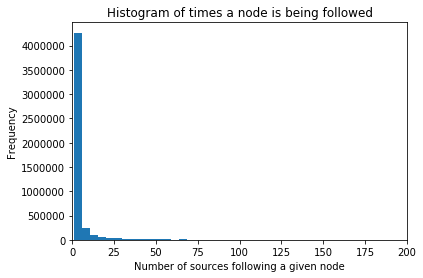

In [6]:
import matplotlib.pyplot as plt

# We create an histogram for exploratory analysis
all_sinks = list(sink_dict.values())
all_sinks.sort()

# Add plot properties (label, title, limits)
plt.title("Histogram of times a node is being followed")
plt.ylabel("Frequency")
plt.xlabel("Number of sources following a given node")
plt.xlim(0, 200)
plt.hist(all_sinks, bins = 1000)

# Show plot
plt.show()

In [8]:
# Filters the data by removing nodes that are being followed less than a threshold (default = 10)
new_sink_dict = filter_sinkNodes(sink_dict, min_neighbours = 10, filter_flag=True)

print ("# Sink nodes after filter:  %s" % (len(new_sink_dict)))

# Sink nodes after filter:  394342


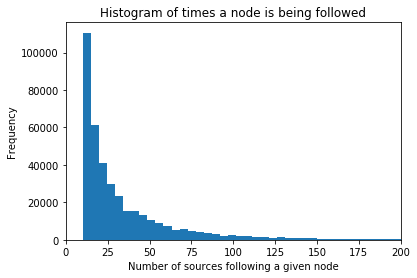

In [9]:
filtered_sinks = list(new_sink_dict.values())
filtered_sinks.sort()
plt.title("Histogram of times a node is being followed")
plt.ylabel("Frequency")
plt.xlabel("Number of sources following a given node")
plt.xlim(0, 200)
plt.hist(filtered_sinks, bins = 1000)
plt.show()

In [10]:
# Join source and sink nodes into a new set
train_source_sink_set = source_nodes.union(set(new_sink_dict))

print ("# Total set (Source and sink train set):\t%s" % (len(train_source_sink_set)))

# Total set (Source and sink train set):	398803


In [11]:
# Read data and extract a dictionary of sink nodes frequency
test_dict = read_data(TEST_FILE, header=True)[1]
test_source_sink_nodes = set(test_dict.keys())

print ("# Test set nodes:\t%s" % (len(test_source_sink_nodes)))

# Test set nodes:	3948


In [12]:
# Create a list node list by join the train and test nodes
total_nodes = train_source_sink_set.union(test_source_sink_nodes)

print ("# Total nodes (Train and test set):\t%s" % (len(total_nodes)))

# Total nodes (Train and test set):	399386


In [13]:
# Create an index and an inverted index, in order to have a unique Id for each node
index, inv_index = build_index(total_nodes)

In [14]:
# Create a list of tuples (source, sink). As For nodes that follows more than 1000 users, we consider the top X more important.
# For estimating the Top X, we use the number of followers as rank metric
tuples, train_tuples = build_tuples(TRAIN_FILE, sink_dict, total_nodes, inv_index, max_neighbours=1000, row_num=1000, filter_flag = True)

print ("# All Tuples (source, sink):\t\t\t%s" % (len(tuples)))
print ("# Random Train set Tuples (source, sink):\t%s" % (len(train_tuples)))

# All Tuples (source, sink):			5167605
# Random Train set Tuples (source, sink):	1000


In [15]:
# We create a direct graph using library networkx
graph = build_DiGraph(tuples, index.keys())
print ("Graph Ready")

Graph Ready


In [16]:
# Get a set with all source nodes than doesn't follow anyone
no_followers_source = get_noFollowersSource(TRAIN_FILE)
real_source_nodes = source_nodes.difference(no_followers_source)
core_source = get_coreSource(real_source_nodes)

# We build a list with fake edges (Note: this step use random values, therefore each time will have different data)
fake_tuple_list = build_fakeEdge(graph, real_source_nodes, core_source, inv_index, len(train_tuples), tuples, random_type='triangle')

print ("# Fake Tuples (source, sink):\t%s" % (len(fake_tuple_list)))

# Fake Tuples (source, sink):	1000


In [17]:
# Concatenate the real tuples list with the fake tuple list for creating full dataset.
full_tuple_list = train_tuples + fake_tuple_list
label = np.concatenate((np.ones(len(train_tuples), dtype=int), np.zeros(len(fake_tuple_list), dtype=int)))

# We create full list index
full_list_index = {}
full_list_inv_index = {}

for i, tuple in enumerate(full_tuple_list):
    full_list_index[i] = tuple
    full_list_inv_index[tuple] = i

print ("# label list:\t\t%s" % (len(label)))
print ("# Total Tuples list:\t%s" % (len(full_tuple_list)))

# label list:		2000
# Total Tuples list:	2000


In [18]:
"""STAGE 2: FEATURE CONSTRUCTION """

# We create a pandas dataframe with the training set tuples
ids = np.array(list(full_list_index.keys()))
ss_nodes = np.array(full_tuple_list)
invflag, cf_out, cf_in, cf_all, fm, pa_score, tf, sp, id_n1, id_n2, od_n1, od_n2, bd_n1, bd_n2, js_in, js_out, js_all, aa_score, ra_score, gb_score = build_Features(graph, full_tuple_list, len(train_tuples), new_sink_dict, sink_follows_dict)

d = {'ids': ids,
     'Source': ss_nodes[:,0],
     'Sink': ss_nodes[:,1],
     'opp_dir_flag': invflag,
     'common_friends_in' : cf_in,
     'common_friends_out' : cf_out,
     'total_friends' : cf_all,
     'friends_measure' : fm,
     'pa_score' : pa_score,
     'transitive_friends' : tf,
     'shortest_path' : sp,
     'in-degree source' : id_n1,
     'in-degree sink' : id_n2,
     'out-degree source' : od_n1,
     'out-degree sink' : od_n2,
     'bi-degree source' : bd_n1,
     'bi-degree sink' : bd_n2,
     'Jaccard similarity in' : js_in,
     'Jaccard similarity out' : js_out,
     'Jaccard similarity all' : js_all,
     'Adamic Adar score' : aa_score,
     'Resource Allocation score' : ra_score,
     'GB index' : gb_score,
     'label' : label}

df = pd.DataFrame(data=d)

df

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


,ids,Source,Sink,opp_dir_flag,common_friends_in,common_friends_out,total_friends,friends_measure,pa_score,transitive_friends,...,out-degree sink,bi-degree source,bi-degree sink,Jaccard similarity in,Jaccard similarity out,Jaccard similarity all,Adamic Adar score,Resource Allocation score,GB index,label
0,0,177237,168244,0,16,0,1642,202695,782068,141,...,0,21,0,0.021144,0.001001,0.095006,-499.291710,0.092620,0.474313,1
1,1,203696,283360,0,3,74,1953,36496,1027092,4,...,999,138,41,0.019417,0.038961,0.038914,-218.518805,0.225455,0.811031,1
2,2,381477,338701,0,1,0,1077,1721,55296,1,...,0,70,0,0.013423,0.001000,0.002786,-3.002166,0.000995,0.467623,1
3,3,317533,208295,0,1,0,59,75,416,1,...,0,6,0,0.142857,0.018868,0.050847,-1.447158,0.035714,0.201574,1
4,4,272959,24072,0,4,0,178,975,8160,3,...,0,22,0,0.037594,0.014493,0.033708,-12.264124,0.003448,0.167682,1
5,5,107948,293439,0,3,0,1151,19818,128092,5,...,0,45,0,0.019900,0.001000,0.006950,-18.256066,0.005448,0.461637,1
6,6,84034,71092,0,0,0,1561,85148,609636,51,...,0,1,0,0.001626,0.001000,0.033953,-163.543122,0.032738,0.469885,1
7,7,381834,71372,0,1,0,1059,39180,64192,7,...,0,0,0,0.029412,0.001000,0.009443,-24.182778,0.007675,0.467014,1
8,8,264260,212392,1,108,187,1993,92900,1249348,100,...,999,242,188,0.196429,0.104362,0.122930,-704.927346,0.536310,0.895549,1
9,9,270610,148979,0,3,0,1154,6561,73030,0,...,0,287,0,0.009029,0.001000,0.004333,-9.072534,0.002838,0.455141,1


In [19]:
"""STAGE 3: SPLIT THE DATA IN TRAIN / HOLDOUT SET """

# We split the training set into train and a holdout set
df_train, df_holdout = train_test_split(df, test_size=0.1, random_state=42)

Y_train = df_train['label']
Y_holdout = df_holdout['label']
X_train = df_train.drop(['label', 'Source', 'Sink', 'ids'], axis = 1)
X_holdout = df_holdout.drop(['label', 'Source', 'Sink', 'ids'], axis = 1)

print ("# Train set length:\t\t%s" % (len(df_train)))
print ("# Holdout set length:\t\t%s" % (len(df_holdout)))

# Train set length:		1800
# Holdout set length:		200


In [20]:
"""STAGE 4: BUILDING THE MODEL """

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Creates a scaler function for normalising the data
scaler = StandardScaler()                                               # Required for scaling values for KNN

# List of all classifiers used for testing results 
classifiers = [
                KNeighborsClassifier(n_neighbors=30, p=1),               # KNN with manhattan distance
                KNeighborsClassifier(n_neighbors=30, p=2),               # KNN with euclidian distance
                #RandomForestClassifier(),
                #GradientBoostingClassifier()
                ]


# We model and test all classifiers using pipelines in holdout set
for model in classifiers:
    steps=[('scaler', scaler), ('model', model)]
    pipe = Pipeline(steps)
    pipe.fit(X_train,Y_train)
    
    Y_prediction = pipe.predict(X_holdout)
    
    print("--------------------------------------------------------------------------")
    print("%s\n\n\t\tAUC score: %s" % (model , roc_auc_score(Y_holdout, Y_prediction)))


--------------------------------------------------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=1,
           weights='uniform')

		AUC score: 0.9653465346534653
--------------------------------------------------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

		AUC score: 0.9551455145514551


In [ ]:
"""STAGE 5: CREATE PREDICTIONS IN TEST SET """

# We read the test data
test_edge_list = []

with open(TEST_FILE) as test_data:
    for i , lines in enumerate(test_data):
        
        if i == 0:                              # Skips the header
            continue;
        
        node_list = lines[:-1].split('\t')
        test_edge_list.append((inv_index[node_list[1]], inv_index[node_list[2]]))


# We create a pandas dataframe with the training set tuples
invflag, cf_out, cf_in, cf_all, fm, pa_score, tf, sp, id_n1, id_n2, od_n1, od_n2, bd_n1, bd_n2, js_in, js_out, js_all, aa_score, ra_score = build_Features(graph, test_edge_list, 0, new_sink_dict, sink_follows_dict)

d = {
     'opp_dir_flag': invflag,
     'common_friends_in' : cf_in,
     'common_friends_out' : cf_out,
     'total_friends' : cf_all,
     'friends_measure' : fm,
     'pa_score' : pa_score,
     'transitive_friends' : tf,
     'shortest_path' : sp,
     'in-degree source' : id_n1,
     'in-degree sink' : id_n2,
     'out-degree source' : od_n1,
     'out-degree sink' : od_n2,
     'bi-degree source' : bd_n1,
     'bi-degree sink' : bd_n2,
     'Jaccard similarity in' : js_in,
     'Jaccard similarity out' : js_out,
     'Jaccard similarity all' : js_all,
     'Adamic Adar score' : aa_score,
     'Resource Allocation score' : ra_score}


df_test = pd.DataFrame(data=d)
df_test

In [ ]:
predictions = model.predict(df_test)
df_test_1 = pd.read_csv(TEST_FILE,delimiter='\t')
d = {'Id': df_test_1['Id'],'Prediction': predictions}
output = pd.DataFrame(data=d)
output.to_csv('Kaggle_prediction.csv',sep=",",index=False)